# Food Vision

The purpose of this notebook is to classify images of food into 101 categories

## Get helper functions

We will be using helper funcitons design by Daniel Brouke

The script we've got available can be found on GitHub https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py





In [1]:
!python -m wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


Saved under helper_functions (1).py


In [2]:
# Import series of helper functions for the notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

## Use TensorFlow Datasets to download data

If you want to get familiar with TensorFlow dataset (TFDS) check out the guide https://www.tensorflow.org/datasets/overview


In [3]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

In [4]:
# List all available datasets
datasets_list = tfds.list_builders() # get all available datasets in TFDS
print('food101' in datasets_list) # Is our food101 dataset in the list of TFDS datasets

True


In [5]:
# Load in the data (takes 5-6 minutes in Google Golab)
(train_data, test_data), df_info = tfds.load(name='food101',
                                             split=["train", "validation"],
                                             shuffle_files=False,
                                             as_supervised=True, # data gets returned in tuples (data, label)
                                             with_info=True) 

## Exploring the Food101 data from Tensorflow datasets

We need to expore the following
* Class names
* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels look like (e.g are they one-hot encoded or are they label encoded)
* Do the labels match up with the class names?

In [6]:
# Features of Food 101 from TFDS
df_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [7]:
# Get the class names
class_names = df_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [8]:
# Take one sample of the train data
train_one_sample = train_data.take(1) # samples are in format (image_tensor, label)

In [9]:
# What does on sample of our traiing data look like
train_one_sample

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [10]:
for image, label in train_one_sample:
    print(f"""
    Image shape: {image.shape},
    Image datatype: {image.dtype},
    Target class from Food101 (tensor form): {label},
    Class name (str form): {class_names[label.numpy()]}
    """)


    Image shape: (512, 512, 3),
    Image datatype: <dtype: 'uint8'>,
    Target class from Food101 (tensor form): 56,
    Class name (str form): huevos_rancheros
    


In [11]:
# What does our image tensor from TFDS's Food101 look like?
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[233, 253, 251],
        [231, 253, 250],
        [228, 254, 251],
        ...,
        [ 85,  82,  89],
        [ 68,  67,  75],
        [ 57,  57,  67]],

       [[232, 254, 252],
        [229, 254, 251],
        [226, 255, 251],
        ...,
        [121, 116, 120],
        [100,  99, 104],
        [ 86,  85,  91]],

       [[228, 254, 253],
        [226, 255, 253],
        [223, 255, 252],
        ...,
        [164, 159, 155],
        [145, 141, 138],
        [128, 127, 125]],

       ...,

       [[ 66, 112, 164],
        [ 67, 113, 163],
        [ 55,  99, 148],
        ...,
        [  5,  14,  23],
        [  9,  18,  27],
        [  8,  17,  26]],

       [[ 76, 123, 177],
        [ 75, 122, 176],
        [ 70, 116, 168],
        ...,
        [  5,  14,  23],
        [  9,  18,  25],
        [  7,  16,  23]],

       [[ 80, 129, 185],
        [ 71, 121, 174],
        [ 74, 121, 175],
        ...,
        [  7,  16,  2

In [12]:
# What are the min and max values of our image tensor
import tensorflow as tf
tf.reduce_min(image), tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

### Plot an image from TensorFlow Dataset

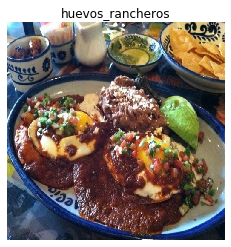

In [13]:
# Plot an image tensor
import matplotlib.pyplot as plt

plt.imshow(image)
plt.title(class_names[label.numpy()]) # Add title to image to verify the label is associated with the image
plt.axis(False);

## Create preprocessing functions on our data

Neural networks perform best when the data is in a certain way (e.g. batched, normalized, etd)

However, not all data (including data from TensorFlow Datasets) come like this

So in order to get it ready for a neural network, you'll often have to write preprocessing functions and map it to your data,

What we know about our data:  
* In `uint8` datatype
* Comprised of all different size tensors (different sized images)
* Not scaled (the pixel values are between 0 & 255)

Whereas, models like data to be:

* In float32 data type (or for mixed precision `float32` and `float16`)
* Have all of the same size tensors (batches require all tensors have the same shape, e.g. (224, 224, 3))
* Scaled (values between 0 & 1), also called normalized

With these points in mind, we've got a few things we  can tackle with a preprocessing function.

Since we're going to be using an EfficientNetBX pretrained model from tf.keras.application we don't need to rescale our data (these architectures have rescaling built-in)

This means our function needs to:
1. Reshape our images to all the same size
2. Comvert the dtype of our image tensors from `uint8` to `float32`

In [14]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Convert image datatype from uint8 -> float32 and
    reshapes image to (img_shape, img_shape, color_channels)
    """
    image = tf.image.resize(image, (img_shape, img_shape)) # reshape target image
    #image = image/255. # scale image values (not required with EfficienetBX modes from tf.keras.applications)
    return tf.cast(image, tf.float32), label # return (float32_imgae, label) tuple

In [15]:
# Preprocess a single image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}\n")

Image before preprocessing:
 [[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]...,
Shape: (512, 512, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[230.65816 253.64285 251.     ]
  [222.99998 254.97449 252.19388]
  [207.06633 255.      250.36734]
  ...
  [140.66287 129.52519 121.22428]
  [121.14268 115.26515 116.95397]
  [ 83.95363  83.08119  89.63737]]

 [[221.47449 254.37755 253.33163]
  [214.5102  255.      253.92348]
  [198.41327 254.58673 251.96939]
  ...
  [208.66318 195.82143 173.40823]
  [197.03056 190.1071  174.83162]
  [175.54036 171.6169  161.21384]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>



## Batch and prepare datasets

We're now going to make our data input pipeline run really fast
For more resources on this : https://www.tensorflow.org/guide/data_performance

In [16]:
# Map preprocessing function to training (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map preprocessing function to test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [17]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)


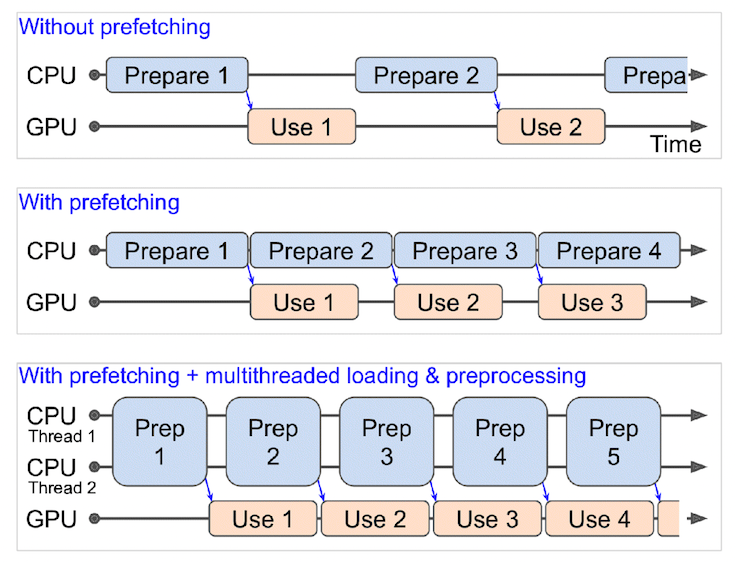

## Create modelling callbacks

We're going to create a couple of callbacks to help us while our model trains: 
* TensorBoard callback to log training results (so we can visualize them later if needed)
* ModelCheckpoint callback to save our model's progress after feature extraction

In [18]:
# Create tensorboard callback (import from helper_functions.py)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save a model's progress during training
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      montior="val_acc", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

## Build feature extraction model

In [19]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
# Note: EfficientNetBX modeld have resacling built-in but if your model doesn't you can have a layer like below
# x = preprocessing.Resacling(1/255.)(x)

x = base_model(inputs, training=False) # makes sure layers which should be in inference mode only
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype=tf.float32, name='softmax_float32')(x)

model = tf.keras.Model(inputs, outputs)

# Use sparse_categorical_crossentropy when labels are *not* one-hot
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])


In [20]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activation  (None, 101)              0         
 )                                                               
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

## Fit the feature extraction model

If our goal is to fine-tune a pretrained model, the general order of doing things is:
1. Build a feature extraction model (train a couple output layers with base layers frozen)
2. Fine-tune some of the frozen layers

In [21]:
# Fit the feature extraction model with callbacks

history_101_food_classes_feature_extract = model.fit(train_data, 
                                                     epochs=1,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     callbacks=[create_tensorboard_callback("training_logs", 
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20211212-115929


C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 3609s 2s/step - loss: 1.8229 - accuracy: 0.5574 - val_loss: 1.2244 - val_accuracy: 0.6756


In [22]:
# Evaluate model on whole test dataset
results_feature_extract_model = model.evaluate(test_data)
results_feature_extract_model

790/790 [==============================] - 747s 945ms/step - loss: 1.2326 - accuracy: 0.6749


[1.232622504234314, 0.6748514771461487]

## Save the whole model to file

In [29]:
# Save model locally (if you're using Google Colab, your saved model will Colab instance terminates)
save_dir = '/models/Food Vision Big'
model.save(save_dir)

INFO:tensorflow:Assets written to: models/Food Vision Big\assets


INFO:tensorflow:Assets written to: models/Food Vision Big\assets
C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\ProgramData\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [30]:
# Load model previously saved above
loaded_saved_model  = tf.keras.models.load_model(save_dir)

In [31]:
# Check the layers in the base model
for layer in loaded_saved_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable)

input_1 True
rescaling False
normalization False
stem_conv_pad False
stem_conv False
stem_bn False
stem_activation False
block1a_dwconv False
block1a_bn False
block1a_activation False
block1a_se_squeeze False
block1a_se_reshape False
block1a_se_reduce False
block1a_se_expand False
block1a_se_excite False
block1a_project_conv False
block1a_project_bn False
block2a_expand_conv False
block2a_expand_bn False
block2a_expand_activation False


In [27]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 1469s 2s/step - loss: 1.2326 - accuracy: 0.6749


[1.232622504234314, 0.6748514771461487]

In [34]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
import numpy as np
assert np.isclose(results_loaded_saved_model,results_feature_extract_model).all()

##  Preparing our model's layers for fine-tuning

In [35]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
for layer in loaded_saved_model.layers:
    layer.trainable = True
    print(layer.name, layer.trainable)

input_layer True
efficientnetb0 True
global_average_pooling2d True
dense True
softmax_float32 True


In [41]:
# Keep only the last 5 layers of the efficient layer as unfrozen
for layer in loaded_saved_model.layers[1].layers[:-5]:
    layer.trainable = False

In [42]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)


# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more

checkpoint_path = "fine_tune_checkpoints/" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor='val_loss',
                                                      save_best_only=True)

# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patinence=2,
                                                 verbose=1,
                                                 min_lr=1e-7)

In [43]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate

loaded_saved_model.compile(loss='sparse_categorical_crossentropy',
                        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                        metrics=['accuracy'])

In [45]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier

history_101_food_classes_all_data_fine_tune = loaded_saved_model.fit(train_data,
                                                                  epochs=1,
                                                                  steps_per_epoch = len(train_data),
                                                                  validation_data=test_data,
                                                                  validation_steps=int(0.15 * len(test_data)),
                                                                  callbacks=[create_tensorboard_callback('training_logs', 'efficientb0_101_classes_all_data_fine_tuning'),
                                                                             model_checkpoint, early_stopping, reduce_lr])

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20211212-143854
2368/2368 [==============================] - ETA: 0s - loss: 1.1947 - accuracy: 0.6893INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets


INFO:tensorflow:Assets written to: fine_tune_checkpoints\assets
C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2368/2368 [==============================] - 4910s 2s/step - loss: 1.1947 - accuracy: 0.6893 - val_loss: 1.0396 - val_accuracy: 0.7148 - lr: 1.0000e-04


C:\ProgramData\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [46]:
loaded_saved_model.save("/models/07_efficientnetb0_fine_tuned_101_classes")

INFO:tensorflow:Assets written to: /models/07_efficientnetb0_fine_tuned_101_classes\assets


INFO:tensorflow:Assets written to: /models/07_efficientnetb0_fine_tuned_101_classes\assets
C:\ProgramData\Anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
C:\ProgramData\Anaconda3\lib\site-packages\keras\saving\saved_model\layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [48]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 1303s 2s/step - loss: 1.0500 - accuracy: 0.7158


[1.0500001907348633, 0.7157623767852783]

In [52]:
pred_probs = loaded_saved_model.predict(test_data)
pred_probs

array([[9.8113494e-04, 5.2609207e-06, 1.7641988e-06, ..., 8.8887714e-04,
        9.0729467e-05, 7.2977692e-02],
       [1.4831670e-04, 1.1708588e-05, 1.9214778e-04, ..., 1.4366125e-04,
        6.6953379e-04, 7.4935284e-05],
       [1.0705946e-05, 3.7945811e-05, 2.2547618e-05, ..., 1.3375906e-06,
        1.6975693e-05, 3.1470286e-06],
       ...,
       [1.2988988e-01, 8.2296210e-05, 6.6155972e-06, ..., 3.0739754e-04,
        3.0851664e-04, 1.9420249e-02],
       [2.3570057e-05, 5.1189772e-08, 1.8962485e-06, ..., 6.2527107e-07,
        5.1033385e-07, 1.3360218e-05],
       [3.8717363e-03, 1.5251088e-04, 9.3292119e-04, ..., 7.1822472e-02,
        7.5416040e-04, 7.3253480e-04]], dtype=float32)

In [53]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([29, 81, 91, 53, 97, 97, 10, 31,  3, 94], dtype=int64)

In [54]:
y_labels = []
for image, label in test_data.unbatch():
    y_labels.append(label.numpy())
y_labels[:10]

[29, 81, 91, 53, 97, 97, 10, 31, 3, 100]

In [55]:
# Find the precision, recall and f1 scores for each class (all 101).
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels, y_pred=pred_classes))

              precision    recall  f1-score   support

           0       0.61      0.36      0.46       250
           1       0.80      0.63      0.70       250
           2       0.77      0.74      0.76       250
           3       0.86      0.71      0.78       250
           4       0.57      0.65      0.61       250
           5       0.59      0.67      0.63       250
           6       0.75      0.88      0.81       250
           7       0.81      0.88      0.85       250
           8       0.48      0.48      0.48       250
           9       0.68      0.57      0.62       250
          10       0.70      0.52      0.59       250
          11       0.76      0.74      0.75       250
          12       0.78      0.73      0.75       250
          13       0.72      0.62      0.67       250
          14       0.76      0.71      0.74       250
          15       0.59      0.48      0.53       250
          16       0.50      0.64      0.56       250
          17       0.71    

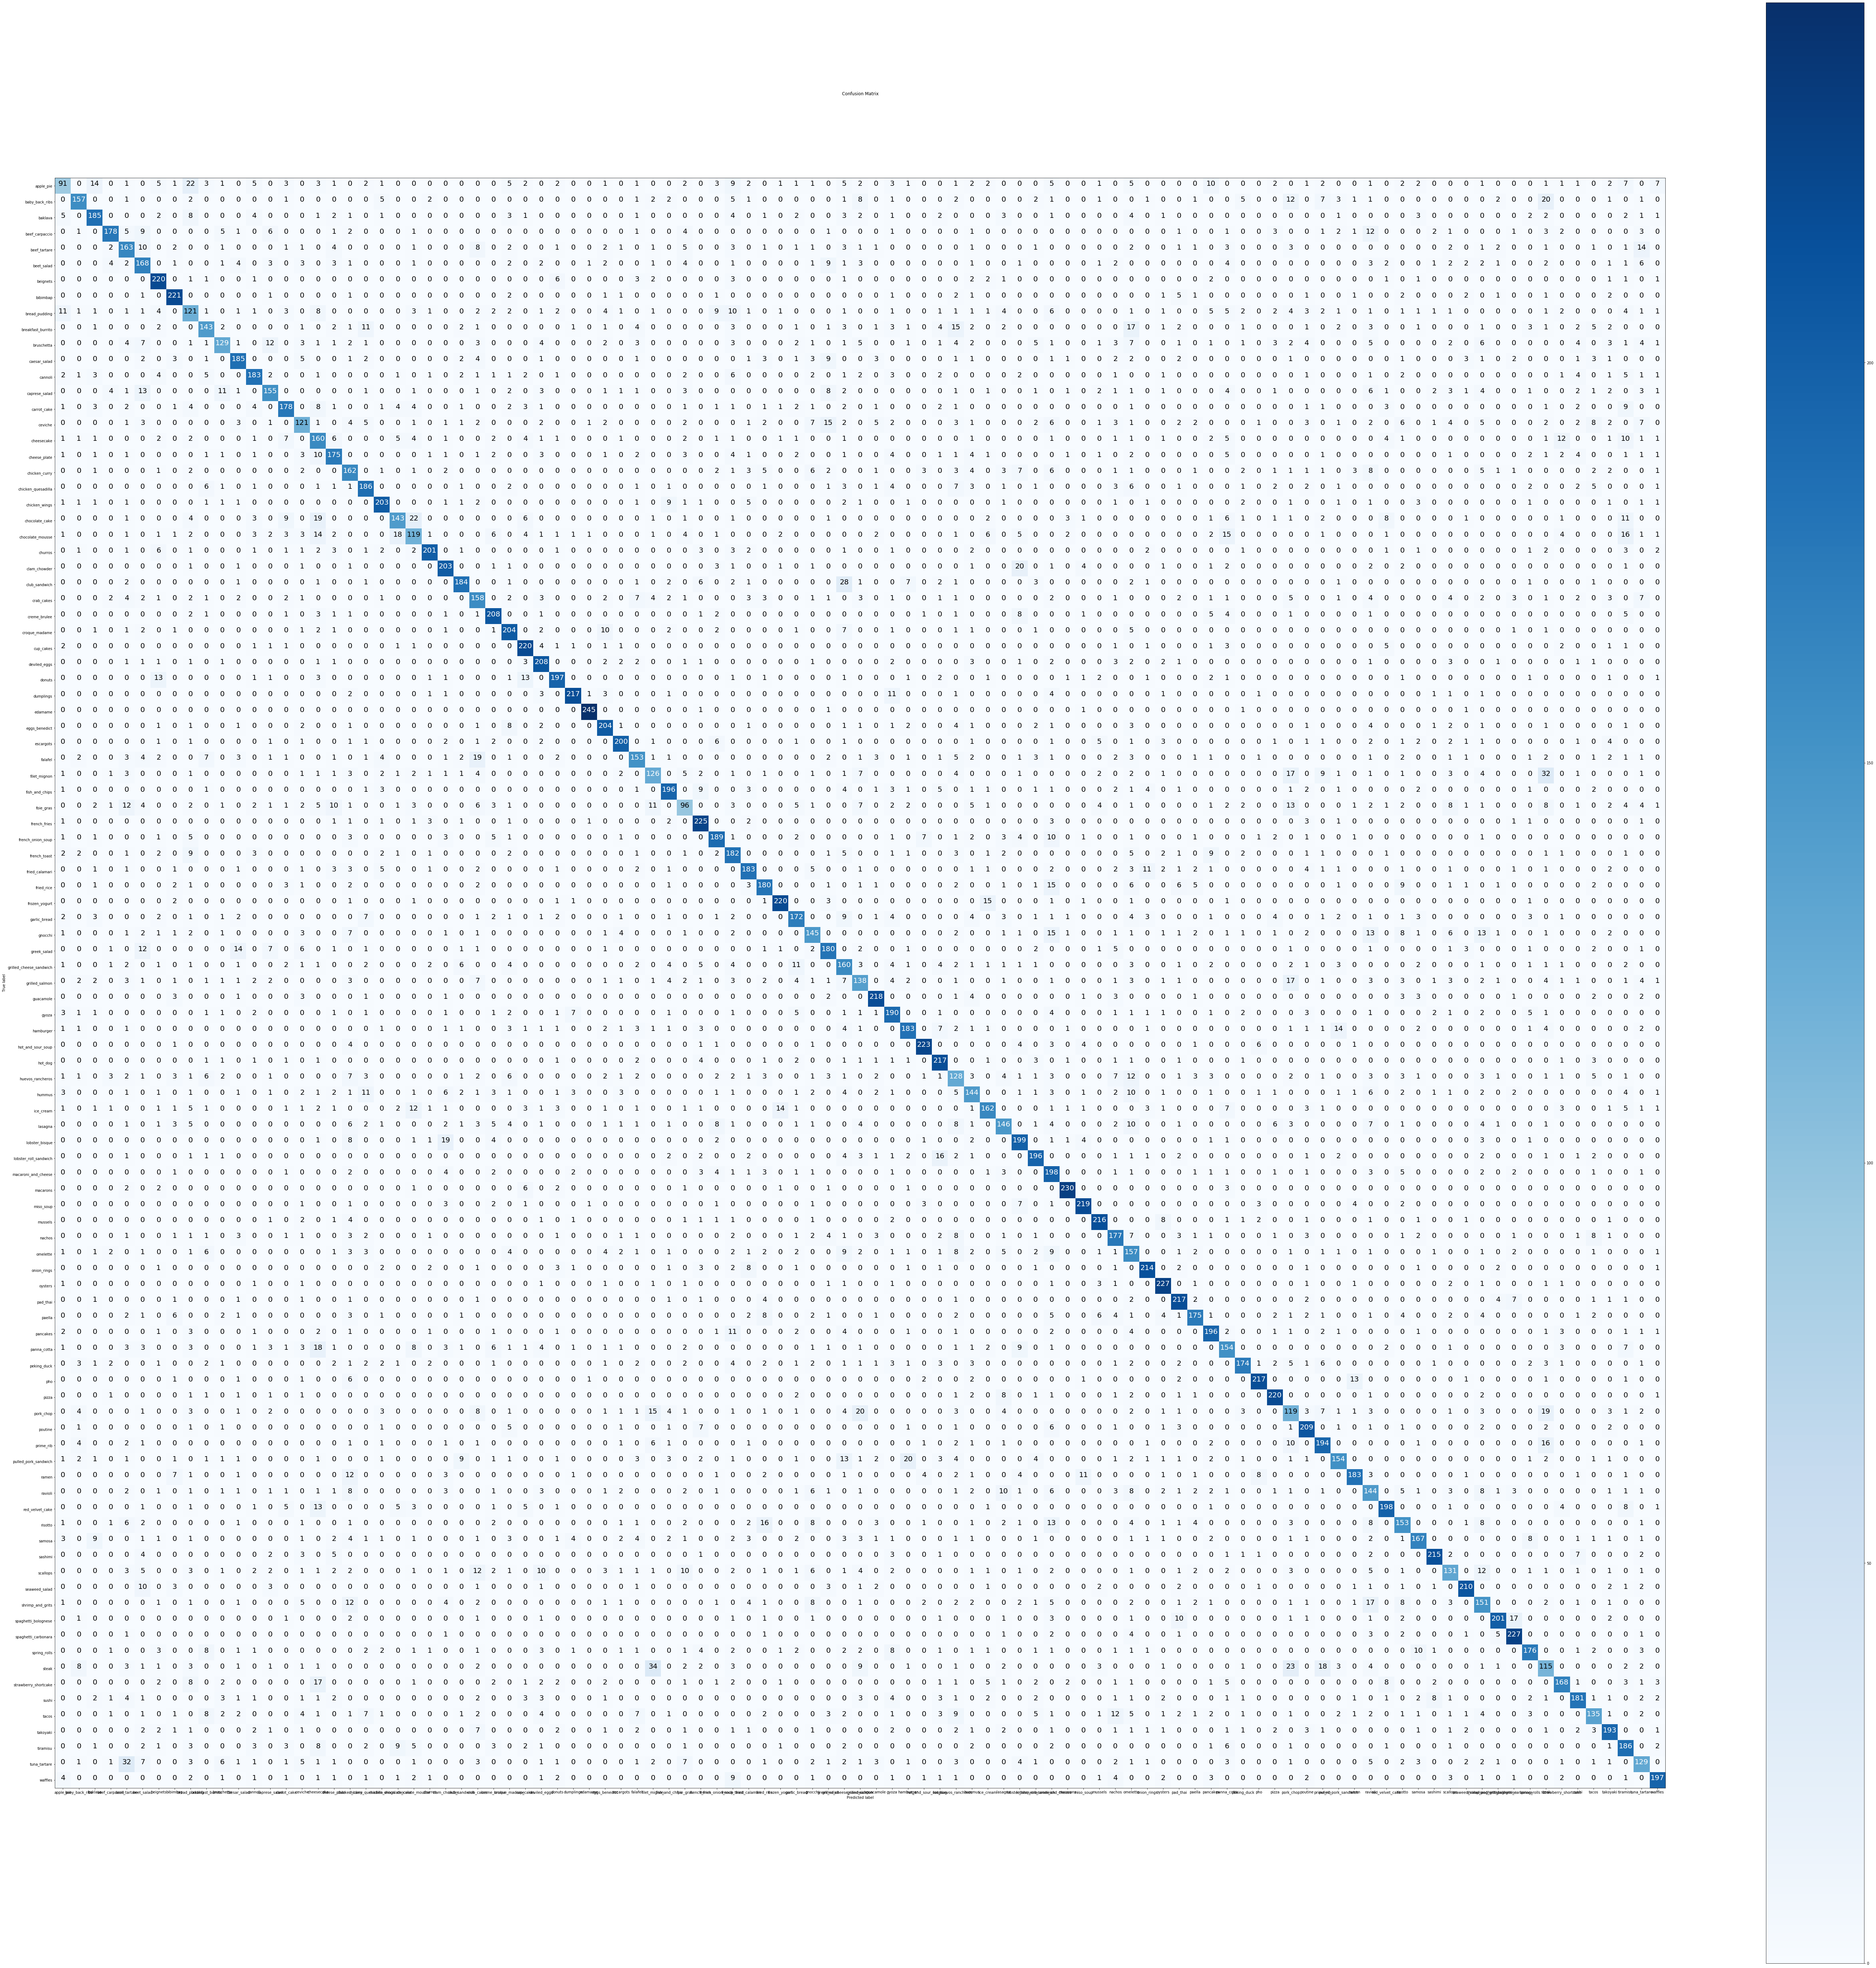

In [56]:
# Build a confusion matrix for each of the classes.
from helper_functions import make_confusion_matrix

make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=class_names,
                      figsize=(100,100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [57]:
# Find your model's most wrong predictions (those with the highest prediction probability but the wrong prediction).
import pandas as pd
predictions_df = pd.DataFrame({'actual_class': [class_names[i] for i in y_labels],
                               'predicted_class': [class_names[i] for i in pred_classes],
                               'pred_prob': pred_probs.max(axis=1)})
predictions_df.head()

,actual_class,predicted_class,pred_prob
0,cup_cakes,cup_cakes,0.399666
1,ramen,ramen,0.661931
2,spaghetti_carbonara,spaghetti_carbonara,0.866042
3,hamburger,hamburger,0.840809
4,takoyaki,takoyaki,0.864487


In [58]:
predictions_df['pred_correct'] = predictions_df['actual_class'] == predictions_df['predicted_class']
predictions_df.head()

,actual_class,predicted_class,pred_prob,pred_correct
0,cup_cakes,cup_cakes,0.399666,True
1,ramen,ramen,0.661931,True
2,spaghetti_carbonara,spaghetti_carbonara,0.866042,True
3,hamburger,hamburger,0.840809,True
4,takoyaki,takoyaki,0.864487,True


In [59]:
predictions_false = predictions_df[predictions_df['pred_correct'] == False].sort_values('pred_prob', ascending=False)
predictions_false

,actual_class,predicted_class,pred_prob,pred_correct
9735,scallops,deviled_eggs,0.997283,False
9895,carrot_cake,sushi,0.997158,False
13884,garlic_bread,bruschetta,0.993604,False
16129,mussels,oysters,0.992881,False
988,strawberry_shortcake,red_velvet_cake,0.990542,False
...,...,...,...,...
12840,cheese_plate,falafel,0.081097,False
20864,hummus,caesar_salad,0.079045,False
23469,cheesecake,clam_chowder,0.076257,False
14026,creme_brulee,french_fries,0.074881,False
